In [345]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness
import os
import matplotlib.pyplot as plt

In [346]:
data_path = r'C:\Users\narut\OneDrive - University of Hertfordshire\CNN-Data-Science-Project\RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32,

)


Found 4752 files belonging to 9 classes.


In [347]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),   # Randomly flip images horizontally
    RandomRotation(0.2),         # Randomly rotate images by up to 20%
    RandomZoom(0.2),             # Randomly zoom into images by 20%
    RandomBrightness(factor=0.2)        # Randomly increase the brightness
])

# Apply augmentation to the training data
def augment(image, label):
    return data_augmentation(image), label



In [348]:
def normalize_img(image, label):
    image = image/ 255.0  # Scale pixel values to [0, 1]
    return image, label

norm_dataset = dataset.map(normalize_img)


In [349]:
# Shuffle and split the dataset into train, validation, and test sets
train_size = int(0.7 * len(norm_dataset))  # 70% for training
val_size = int(0.15 * len(norm_dataset))   # 15% for validation
test_size = len(norm_dataset) - train_size - val_size  # 15% for testing

train_dataset = norm_dataset.take(train_size)
val_dataset = norm_dataset.skip(train_size).take(val_size)
test_dataset = norm_dataset.skip(train_size + val_size)



In [350]:
train_dataset.map(augment)

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [351]:
for images, labels in train_dataset.take(1):
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")

Min pixel value: 0.0
Max pixel value: 1.0


In [352]:
class_names = sorted(os.listdir(data_path))  # Get folder names
num_classes = len(class_names) 
# Apply one-hot encoding to labels
def process_labels(image, label):
    return image, tf.one_hot(label, num_classes)  # One-hot encoding

train_dataset = train_dataset.map(process_labels)
val_dataset = val_dataset.map(process_labels)
test_dataset = test_dataset.map(process_labels)

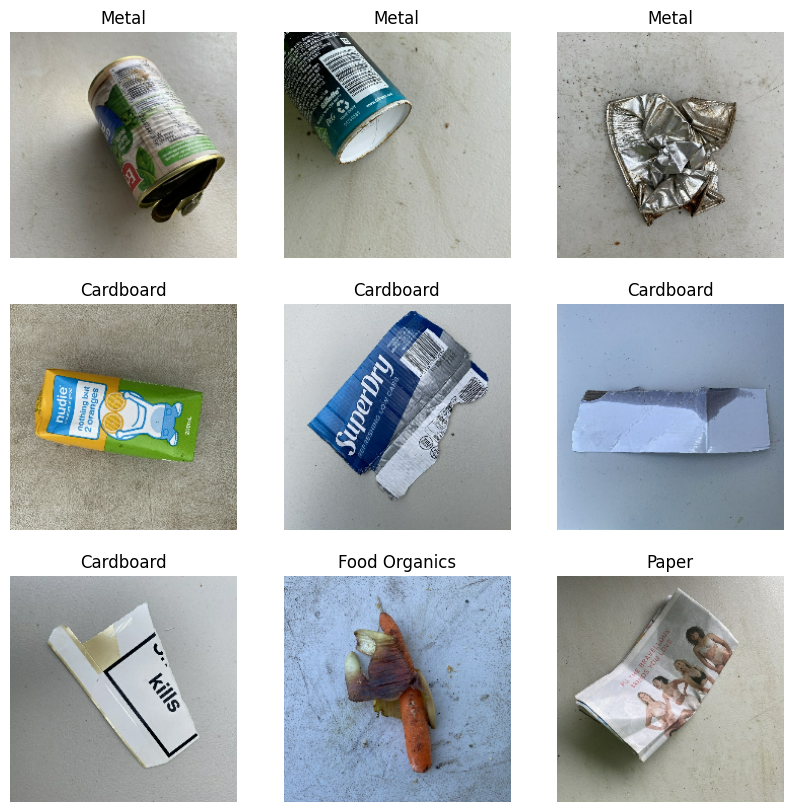

In [353]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    
    for images, labels in dataset.take(1):  # Get one batch
        for i in range(9):  # Display 9 images
            ax = plt.subplot(3, 3, i + 1)
            
            # Ensure image values are in the correct range for displaying (0 to 255)
            img = images[i].numpy()  # Convert to numpy array
            if img.max() <= 1.0:  # If the image is normalized between 0 and 1
                img = img * 255  # Rescale to 0-255
            
            plt.imshow(img.astype("uint8"))  # Convert to valid image format
            
            # Extract the class index from one-hot encoded label
            label_idx = tf.argmax(labels[i]).numpy()  # Get the index of the class
            plt.title(class_names[label_idx])  # Use pre-stored class names
            plt.axis("off")

    plt.show()

visualize_dataset(train_dataset, class_names)

